## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0052 - val_loss: 9.4707e-04
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 8.1357e-04
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9148e-04 - val_loss: 9.2286e-04
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4151e-04 - val_loss: 0.0015
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9219e-04 - val_loss: 0.0015
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5228e-04 - val_loss: 0.0011
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2106e-04 - val_loss: 9.6865e-04
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8887e-04 - val_loss: 6.8025e-04
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1950e-04 - val_loss: 5.7184e-04
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9082e-04 - val_loss: 5.7527e-04
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8007e-04 - val_loss: 4.9752

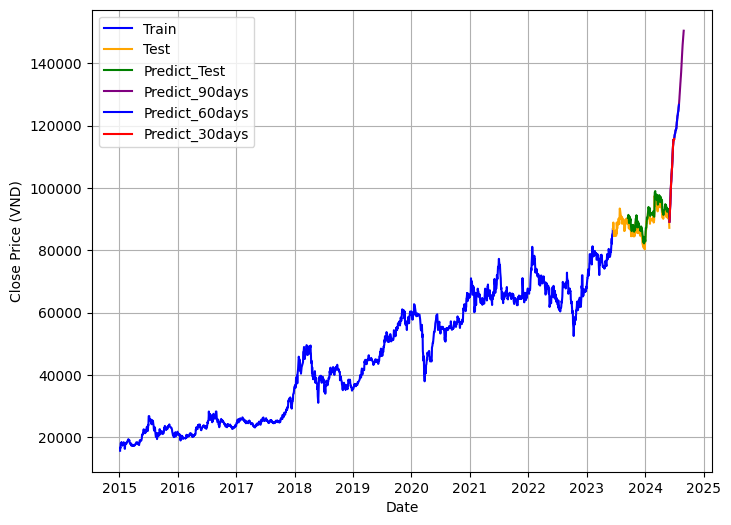

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')

# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)

Forecast VCB stock prices for the next 90 days:
                 Forecast
Date                     
2024-06-01   89199.546875
2024-06-02   90074.992188
2024-06-03   91502.351562
2024-06-04   92847.101562
2024-06-05   93934.960938
...                   ...
2024-08-25  147815.781250
2024-08-26  148550.828125
2024-08-27  149176.312500
2024-08-28  149892.656250
2024-08-29  150457.312500

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 2032.843417366091
MAPE: 1.9827075961844183 %
MAE: 1765.1053340517258


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0453 - val_loss: 0.0012
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3934e-04 - val_loss: 0.0016
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4743e-04 - val_loss: 0.0016
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9247e-04 - val_loss: 0.0018
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5900e-04 - val_loss: 0.0019
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3208e-04 - val_loss: 0.0018
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0948e-04 - val_loss: 0.0015
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8865e-04 - val_loss: 0.0013
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7053e-04 - val_loss: 0.0010
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6783e-04 - val_loss: 4.2544e-04
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7506e-04 - val_loss: 4.0040e-04
Epoch 12/200
64

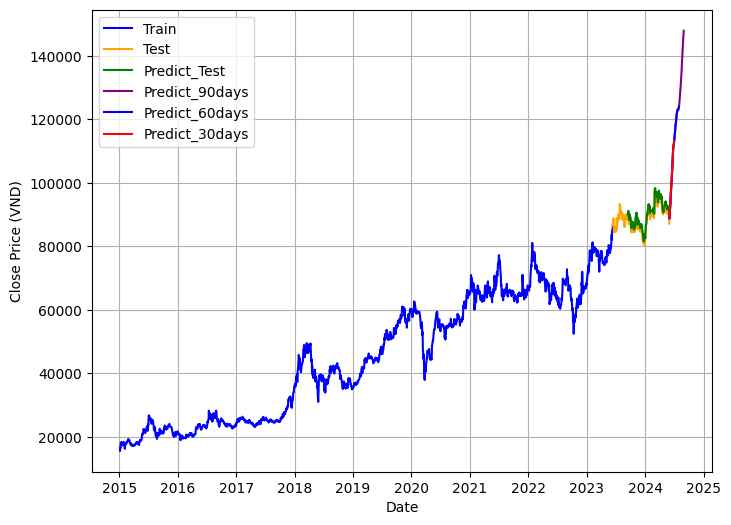

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')

# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)

Forecast VCB stock prices for the next 90 days:
                 Forecast
Date                     
2024-06-01   88884.671875
2024-06-02   89660.851562
2024-06-03   90363.953125
2024-06-04   91445.937500
2024-06-05   92266.101562
...                   ...
2024-08-25  144608.968750
2024-08-26  145475.953125
2024-08-27  146313.375000
2024-08-28  147136.875000
2024-08-29  147921.375000

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1666.6364820870176
MAPE: 1.5764159329223295 %
MAE: 1405.0508261494267


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0198 - val_loss: 0.0017
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5462e-04 - val_loss: 0.0028
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9582e-04 - val_loss: 0.0022
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0898e-04 - val_loss: 0.0016
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5980e-04 - val_loss: 9.4502e-04
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9904e-04 - val_loss: 7.2551e-04
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9086e-04 - val_loss: 0.0011
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0081e-04 - val_loss: 0.0015
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0666e-04 - val_loss: 0.0018
Epoch 12/200
65/65 ━━━━━━━━━━━━━━━━

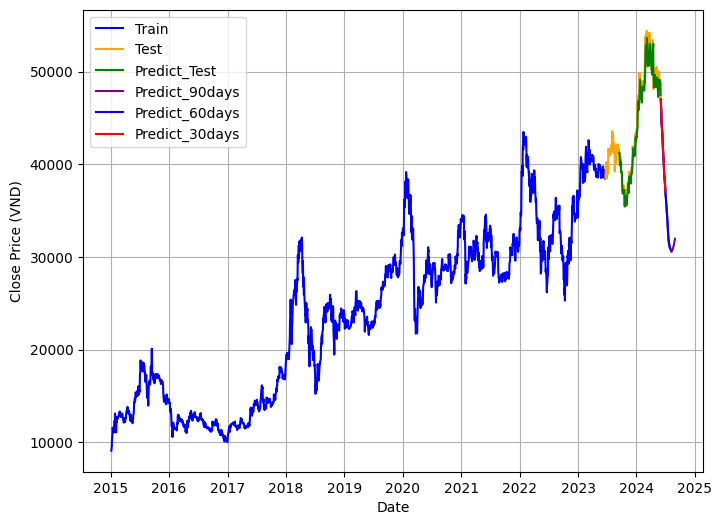

In [10]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')

# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('BID Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)

Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  47012.074219
2024-06-02  46751.527344
2024-06-03  46251.816406
2024-06-04  45785.714844
2024-06-05  45355.886719
...                  ...
2024-08-25  31565.109375
2024-08-26  31673.193359
2024-08-27  31765.052734
2024-08-28  31853.369141
2024-08-29  31959.279297

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 982.0776488460319
MAPE: 1.5476642751778964 %
MAE: 715.51171875
